In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '07_01_24_OCTA_6M_Lab255_SmallToLarge'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 32032 -> 32032 rows.
Finished loading inference stats.
Log amounts: root                                                                        log_set                                              
/storage/vbutoi/scratch/ESE/inference/07_01_24_OCTA_6M_Lab255_SmallToLarge  20240701_154241-OQYW-14d95a1001b1687537a6c704c34924fe    1092
                                                                            20240701_154245-CDC2-d366f620ae4fad5c3efc220052d83fe2    1092
                                                                            20240701_154250-LED6-545076f0a0d34e5bd44bfdcb23d849cb    1092
                                                                            20240701_154253-8H5J-9fd7008f0b1cfc47d7f3c88eae3c9433    1092
                                                                            20240701_154257-R39K-94f598187ded9485c1e52c6e267f2732    1092
                                         

In [4]:
if 'dataset.version' in inference_df.columns:
    inference_df['dataset_version'] = inference_df['dataset.version'].map(lambda x: float(x))
else:
    inference_df['dataset_version'] = 1.0

def loss_func(loss_func_class):
    if loss_func_class == "None":
        return 'Combo'
    else:
        return loss_func_class.split('.')[-1]
    
def resolution(dataset_version):
    if dataset_version == 0.1:
        return "128"
    elif dataset_version == 1.0:
        return "400" 
    else:
        raise ValueError(f"Unknown dataset version {dataset_version}")

inference_df.augment(loss_func)
inference_df.augment(resolution)

# Remove rows corresponding to pretrained seed 42, it crashed.
inference_df = inference_df[inference_df.pretrained_seed != 42].reset_index(drop=True)

# Library Funcs

In [5]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute {value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df


def calibrator(pretrained_exp_root):
    if "SVLS" in pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncal"


def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the proportion_type is hard_proportion_error.
    df = df[~((df['calibrator'] != 'Uncal') & (df['proportion_type'] == f'hard {value_name}'))]
    # Then we augment the proportion_type with the calibrator name.
    def proportion_type(calibrator, loss_func, proportion_type):
        # If the loss function is PixelCELoss, we drop the loss function name.
        if loss_func == "PixelCELoss":
            proc_loss_func = "CE"
        else:
            proc_loss_func = "Dice"

        # If the proportion_type is hard_proportion_error, we drop the calibrator name.
        if proportion_type in ["new gt error", "new gt relative error"]:
            return "New GT"
        elif calibrator == "Uncal":
            return "Uncal " + proportion_type.split(" ")[0] + f" ({proc_loss_func})"
        else:
            return calibrator + " soft" + f" ({proc_loss_func})"
    # Finally, sort by data_id
    df['proportion type'] = df.apply(lambda x: proportion_type(x['calibrator'], x['loss_func'], x['proportion_type']), axis=1)
    df = df.sort_values(by="data_id")
    # Drop the duplicate rows and reset the index.
    df = df.drop_duplicates().reset_index(drop=True)
    # Return the augmented dataframe.
    return df

In [6]:
inference_df

,pred_hash,image_metric,metric_score,batch_idx,split,data_cfg_opt,label_idx,gt_proportion,data_id,inference_resolution,...,out_channels,pred_label,pretrained_exp_root,pretrained_select_metric,_pretrained_class,joint_data_slice_id,method_name,dataset_version,loss_func,resolution
0,-8440437380750282266,Dice,0.327284,0,val,split:val,-1,0.065369,subject_10233.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=41),1.0,SoftDiceLoss,400
1,-8440437380750282266,HD95,44.328857,0,val,split:val,-1,0.065369,subject_10233.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=41),1.0,SoftDiceLoss,400
2,-8440437380750282266,BoundaryIOU,0.195588,0,val,split:val,-1,0.065369,subject_10233.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=41),1.0,SoftDiceLoss,400
3,-8440437380750282266,SoftVolumeError,-792.339844,0,val,split:val,-1,0.065369,subject_10233.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=41),1.0,SoftDiceLoss,400
4,-8440437380750282266,HardVolumeError,-4388.000000,0,val,split:val,-1,0.065369,subject_10233.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=41),1.0,SoftDiceLoss,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30571,-1998111209359601895,Dice Loss,0.390478,6,cal,split:cal,-1,0.095806,subject_10295.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10295.bmp_None,UNet (seed=47),1.0,SoftDiceLoss,400
30572,-1380193546878253571,Dice Loss,0.494258,7,cal,split:cal,-1,0.085194,subject_10051.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10051.bmp_None,UNet (seed=47),1.0,SoftDiceLoss,400
30573,-2425631684322450719,Dice Loss,0.528771,7,cal,split:cal,-1,0.086131,subject_10159.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10159.bmp_None,UNet (seed=47),1.0,SoftDiceLoss,400
30574,8122905553099775650,Dice Loss,0.365010,7,cal,split:cal,-1,0.102288,subject_10096.bmp,128,...,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,None,subject_10096.bmp_None,UNet (seed=47),1.0,SoftDiceLoss,400


In [7]:
# Get the relevant columns for looking at the Dice score and Image ECE
metric_cols = [
    "data_id",
    "loss_func",
    "pretrained_seed",
    "pretrained_exp_root",
    "split",
    "image_metric",
    "metric_score"
]
# Take these columns of the inference_df, drop other columns and delete duplicate rows.
metric_df = inference_df[metric_cols].drop_duplicates().reset_index(drop=True)
metric_df.augment(calibrator)
# Drop the 'pretrained_exp_root column
metric_df = metric_df.drop(columns=["pretrained_exp_root"])

In [8]:
def train_method(calibrator, loss_func):
    return calibrator + f" ({loss_func})"

metric_df.augment(train_method)

In [9]:
metric_df['train_method'].unique()

array(['Uncal (SoftDiceLoss)', 'Uncal (PixelCELoss)',
       'SVLS (PixelCELoss)', 'SVLS (SoftDiceLoss)'], dtype=object)

In [10]:
metric_df['image_metric'].unique()

array(['Dice', 'HD95', 'BoundaryIOU', 'SoftVolumeError',
       'HardVolumeError', 'Image_ECE', 'Image_Edge-ECE', 'Image_CW-ECE',
       'Image_ECW-ECE', 'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE',
       'Dice Loss'], dtype=object)

In [11]:
def shortened_train_method(train_method):
    if train_method == 'Uncal (PixelCELoss)':
        return 'UC-CE'
    elif train_method == 'Uncal (SoftDiceLoss)':
        return 'UC-SD'
    elif train_method == 'SVLS (PixelCELoss)':
        return 'SV-CE'
    elif train_method == 'SVLS (SoftDiceLoss)':
        return 'SV-SD'
    else:
        raise ValueError(f"Unknown train method {train_method}")
    
metric_df.augment(shortened_train_method)

In [12]:
# Finally, we want to change the order that the methods appear in.
metric_df['train_method'] = metric_df['train_method'].astype('category')
metric_df['train_method'] = metric_df['train_method'].cat.reorder_categories([
    'Uncal (PixelCELoss)',
    'Uncal (SoftDiceLoss)',
    'SVLS (PixelCELoss)',
    'SVLS (SoftDiceLoss)',
])
metric_df['shortened_train_method'] = metric_df['shortened_train_method'].astype('category')
metric_df['shortened_train_method'] = metric_df['shortened_train_method'].cat.reorder_categories([
    'UC-CE',
    'UC-SD',
    'SV-CE',
    'SV-SD'
])

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


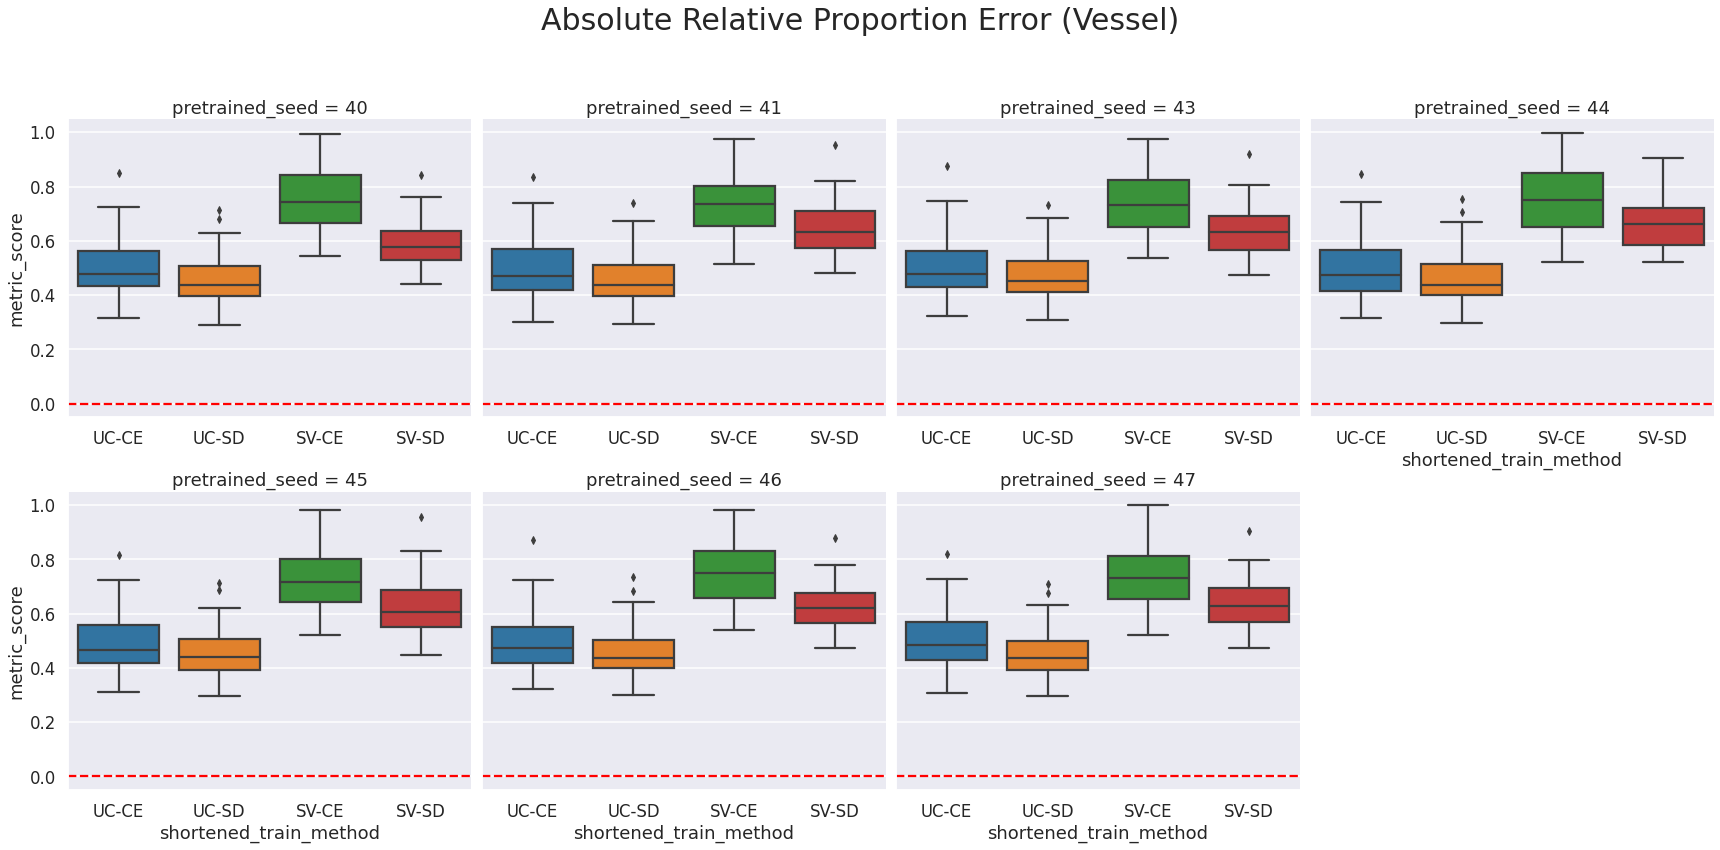

In [13]:
# Get the df for Dice loss
dice_df = metric_df[metric_df['image_metric'] == 'Dice Loss']

# Create the catplot
g = sns.catplot(
    data=dice_df,      # Ensure you use the 'data' parameter correctly.
    x="shortened_train_method",
    y="metric_score",
    col="pretrained_seed",
    kind="box",
    col_wrap=4,
    sharex=False,
    height=6
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Relative Proportion Error (Vessel)', fontsize=30)

# Add some vertical spcace 
plt.subplots_adjust(hspace=0.25)

# Show the plot
plt.show()

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


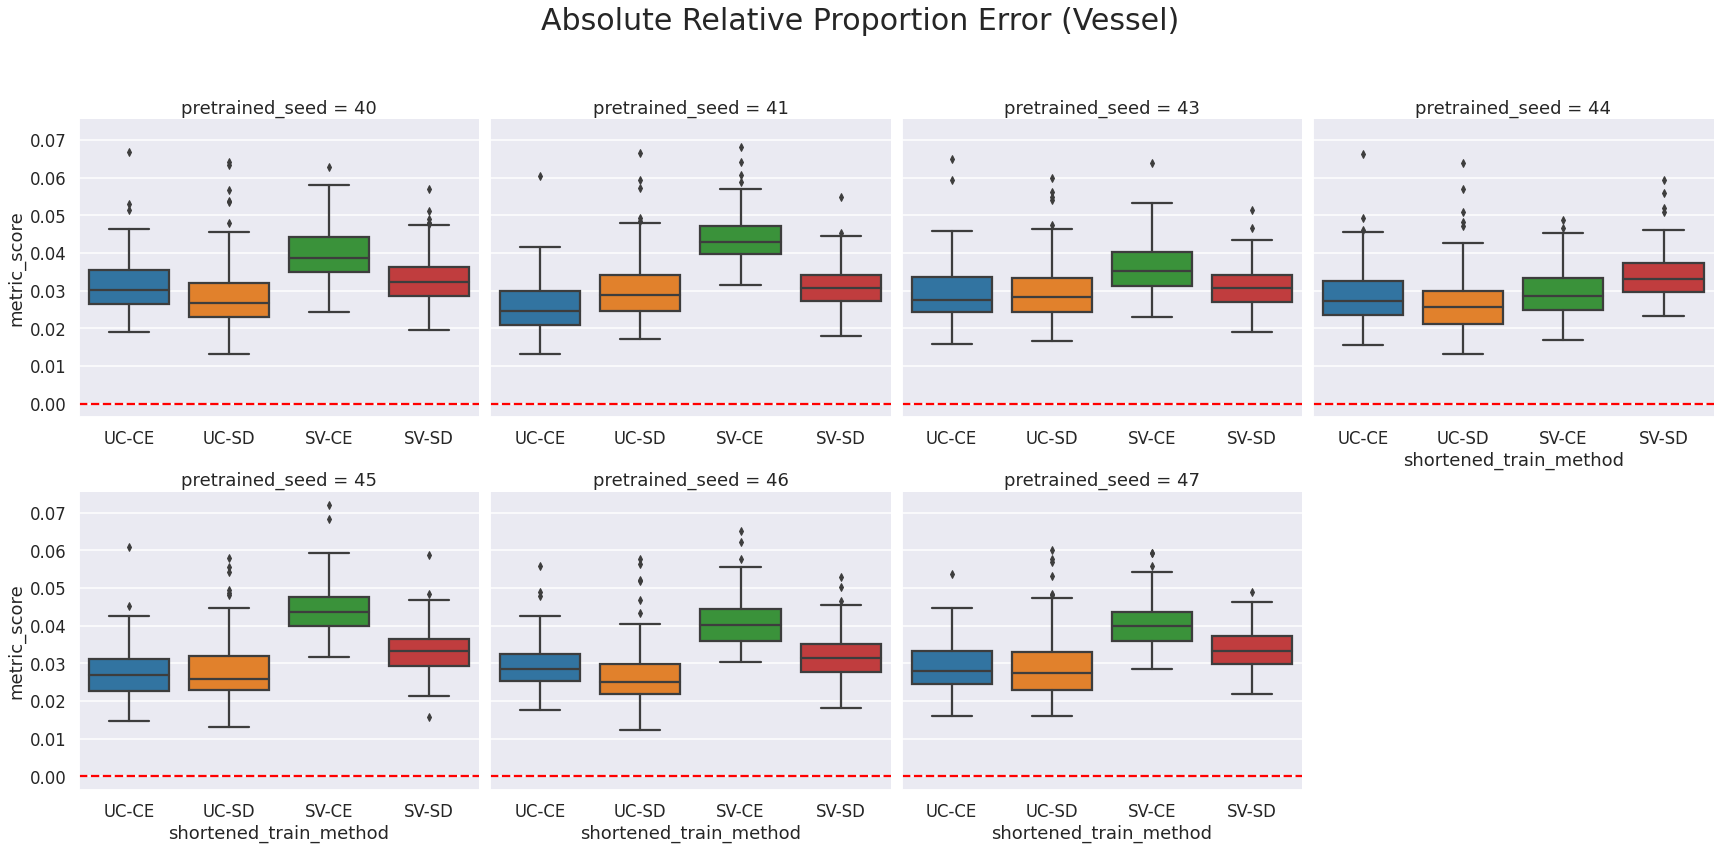

In [14]:
# Get the df for Dice loss
ece_df = metric_df[metric_df['image_metric'] == 'Image_ECE']

# Create the catplot
g = sns.catplot(
    data=ece_df,      # Ensure you use the 'data' parameter correctly.
    x="shortened_train_method",
    y="metric_score",
    col="pretrained_seed",
    kind="box",
    col_wrap=4,
    sharex=False,
    height=6
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Relative Proportion Error (Vessel)', fontsize=30)

# Add some vertical spcace 
plt.subplots_adjust(hspace=0.25)

# Show the plot
plt.show()